# Learn the basics
https://pytorch.org/tutorials/beginner/basics/intro.html
We’ll use the FashionMNIST dataset to train a neural network that predicts if an input image belongs to one of the following classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, or Ankle boot.

# Quickstart
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## Working with Data
PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.
# The torchvision.datasets module contains Dataset objects for many real-world vision data.  Full list here https://pytorch.org/vision/stable/datasets.html


# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating models
To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [14]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the model parameters

In [15]:
# To train a model, we need a loss function and an optimizer.

loss_fn = nn.CrossEntropyLoss()
# Note: lr is learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

# CONTINYA: read through this.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# We also check the model’s performance against the test dataset to ensure it is learning.

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.303091  [   64/60000]
loss: 2.285560  [ 6464/60000]
loss: 2.261251  [12864/60000]
loss: 2.261582  [19264/60000]
loss: 2.244202  [25664/60000]
loss: 2.211489  [32064/60000]
loss: 2.220053  [38464/60000]
loss: 2.180410  [44864/60000]
loss: 2.187643  [51264/60000]
loss: 2.139734  [57664/60000]
Test Error: 
 Accuracy: 40.1%, Avg loss: 2.137699 

Epoch 2
-------------------------------
loss: 2.154352  [   64/60000]
loss: 2.137787  [ 6464/60000]
loss: 2.076304  [12864/60000]
loss: 2.102005  [19264/60000]
loss: 2.043487  [25664/60000]
loss: 1.977694  [32064/60000]
loss: 2.007848  [38464/60000]
loss: 1.919666  [44864/60000]
loss: 1.937872  [51264/60000]
loss: 1.843341  [57664/60000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.849785 

Epoch 3
-------------------------------
loss: 1.895350  [   64/60000]
loss: 1.849263  [ 6464/60000]
loss: 1.733403  [12864/60000]
loss: 1.784315  [19264/60000]
loss: 1.669025  [25664/60000]
loss: 1.620781  [32064/600

# Saving and loading models

In [16]:
# A common way to save a model is to serialize the internal state dictionary (containing the model parameters).
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# The process for loading a model includes re-creating the model structure and loading the state dictionary into it.
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

Saved PyTorch Model State to model.pth


<All keys matched successfully>

In [17]:
# The model can now be used to make predictions

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Tensors

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data.  Tensors are also optimized for automatic differentiation.

In [19]:
import torch
import numpy as np

## Initializing a Tensor

In [22]:
# Directly from data
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

# From a NumPy array
# Tensors can be created from NumPy arrays (and vice versa)
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# From another tensor
# The new tensor retains the properties (shape, datatype) of the argument tensor, unless explicitly overridden.
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

# With random or constant values
# shape is a tuple of tensor dimensions. In the functions below, it determines the dimensionality of the output tensor.
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")


Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.7835, 0.8484],
        [0.9208, 0.1106]]) 

Random Tensor: 
 tensor([[0.0278, 0.8344, 0.1452],
        [0.9731, 0.3883, 0.2312]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


## Attributes of a Tensor

In [23]:
# Tensor attributes describe their shape, datatype, and the device on which they are stored.
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## Operations on Tensors
Over 100 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing), sampling and more are comprehensively described [here](https://pytorch.org/docs/stable/torch.html).

Each of these operations can be run on the GPU (at typically higher speeds than on a CPU). If you’re using Colab, allocate a GPU by going to Runtime > Change runtime type > GPU.

By default, tensors are created on the CPU. We need to explicitly move tensors to the GPU using .to method (after checking for GPU availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!

In [24]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

# Standard numpy-like indexing and slicing
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

# Joining tensors
# You can use torch.cat to concatenate a sequence of tensors along a given dimension. See also torch.stack, another tensor joining operator that is subtly different from torch.cat.
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

# Arithmetic operations

# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)

# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

# Single-element tensors: If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using item():
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

# In-place operations: Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change x.
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])
12.0 <class 'float'>


## Bridge with NumPy
Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.


In [25]:
# Tensor to NumPy array
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")
# A change in the tensor reflects in the NumPy array.
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

# NumPy array to Tensor
n = np.ones(5)
t = torch.from_numpy(n)
# Changes in the NumPy array reflects in the tensor.
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


# Datasets and DataLoaders
PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model.

## Loading a Dataset

Already covered this.  See above

## Iterating and Visualizing the Dataset


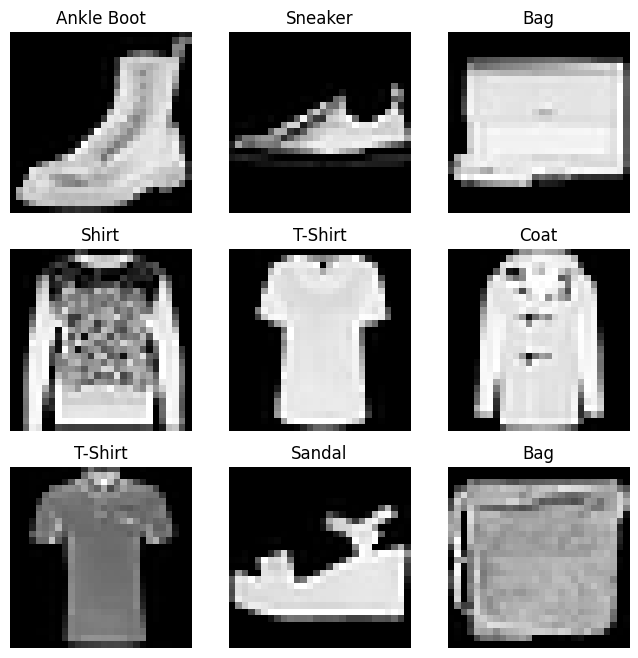

In [27]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):

    # The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).
    # The labels.csv file looks like:
    # tshirt1.jpg, 0
    # tshirt2.jpg, 0
    # ......
    # ankleboot999.jpg, 9
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # The __len__ function returns the number of samples in our dataset.
    def __len__(self):
        return len(self.img_labels)

    # The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


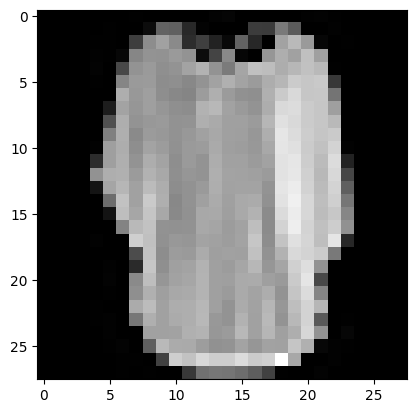

Label: 0


In [33]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.



In [34]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


# Build the Neural Network

Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

# Automatic Differentiation with torch.autograd

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

In [35]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)


## Tensors, Functions and Computational graph

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the `requires_grad` property of those tensors.


In [36]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x142376560>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x142377250>


## Computing Gradients


In [37]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2175, 0.1261, 0.2254],
        [0.2175, 0.1261, 0.2254],
        [0.2175, 0.1261, 0.2254],
        [0.2175, 0.1261, 0.2254],
        [0.2175, 0.1261, 0.2254]])
tensor([0.2175, 0.1261, 0.2254])


## Disabling Gradient Tracking

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [38]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


# Optimizing Model Parameters

Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. 

[see code above]

## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates.

We define the following hyperparameters for training:
- Number of Epochs - the number times to iterate over the dataset
- Batch Size - the number of data samples propagated through the network before the parameters are updated
- Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.


Each epoch consists of two main parts:
- The Train Loop - iterate over the training dataset and try to converge to optimal parameters.
- The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

We pass our model’s output logits to nn.CrossEntropyLoss, which will normalize the logits and compute the prediction error.

In [39]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent).

All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
- Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
- Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.
- Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

[code for train and test loops already featured above]